# Simple baselines example usage
In this notebook we provide an example of applying different baselines on a synthetic dataset. This simulates the case where you want to benchmark your own dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from src.baselines import simple_baselines
from src.evaluation.evaluation import evaluate_methods_on_datasets
from src.dataset_utils.data_utils import preprocess_data
from src.dataset_utils.data_utils import normalise_scores

from src.dataset_utils.synthetic_series import synthetic_dataset_with_out_of_range_anomalies, plot_series_and_predictions

## Generate the synthetic dataset and check the test data.

In [31]:
data, anomaly_locations = synthetic_dataset_with_out_of_range_anomalies(
    number_of_sensors=4,
    ratio_of_anomalous_sensors=0.5
)

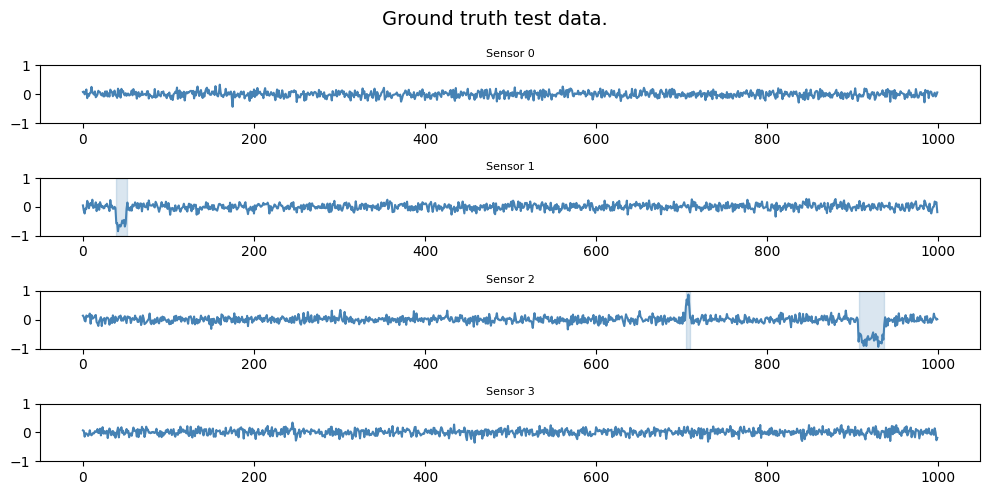

In [32]:
plot_series_and_predictions(
    series=data['test'], 
    gt_anomaly_intervals=anomaly_locations,
)

## Evaluate the baselines

In [33]:
baselines_dict = {
    'Simple L2_norm': simple_baselines.LNorm(ord=2),
    'PCA_Error': simple_baselines.PCAError(pca_dim='auto', svd_solver='full')
}

In [34]:
scores_df = evaluate_methods_on_datasets(
    methods=baselines_dict,
    datasets={'synthetic': data},
    data_normalization='0-1',
    score_normalization='optimal',
    eval_method='point_wise',
    verbose=False
)

Adjusting estimated number of PCA components from 10 to 2.


In [35]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
(
    scores_df
    .style
    .format(precision=3)
    .apply(highlight_max, props='color:white;background-color:darkblue', axis=0)
)

## Train the baselines on the data

In [36]:
# Preprocess the data.
train, _, test = preprocess_data(
    data['train'],
    data['test'],
    train_size=0.98,
    val_size=0.02,
    normalization='0-1'
)

In [37]:
# Initialize the methods.
l2norm = simple_baselines.LNorm(ord=2)
pca_error = simple_baselines.PCAError(pca_dim='auto', svd_solver='full')

In [38]:
# Train on the data and predict. L2-Norm needs not fitting.
pca_error.fit(train)

l2norm_preds = l2norm.transform(test)
pca_error_preds = pca_error.transform(test)

# Normalize the scores.
l2norm_preds = normalise_scores(l2norm_preds, norm='mean-iqr')
pca_error_preds = normalise_scores(pca_error_preds, norm='mean-iqr').max(1)

Adjusting estimated number of PCA components from 10 to 2.


## Visualize the preditions

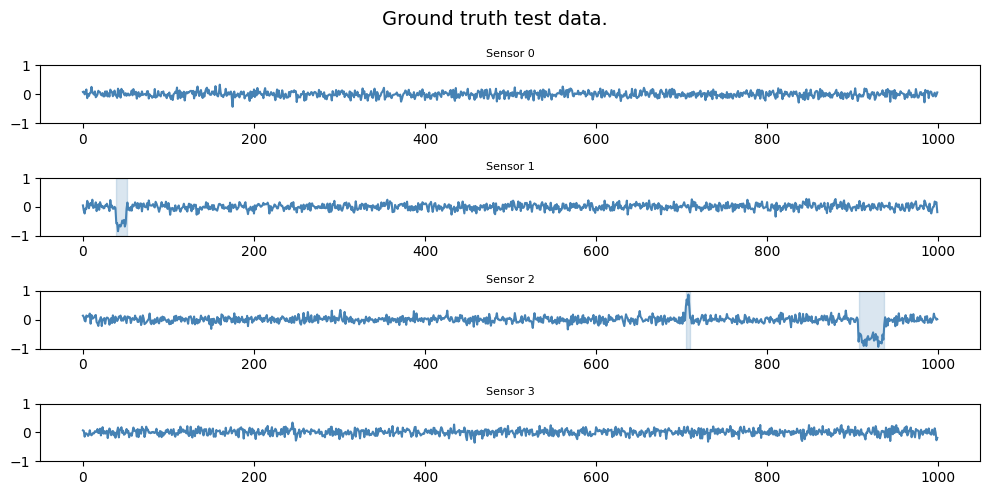

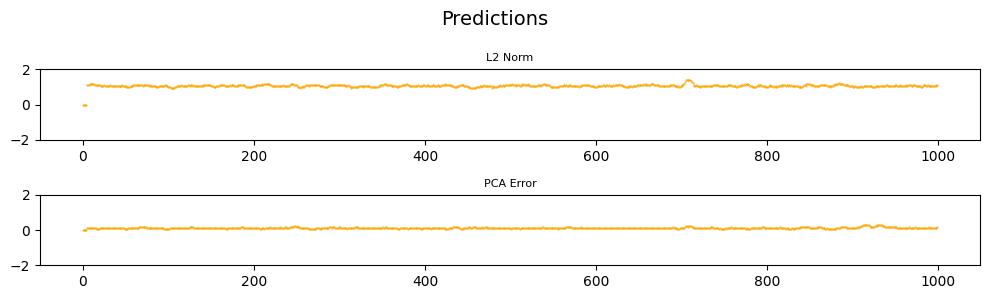

In [39]:
plot_series_and_predictions(
    series=data['test'], 
    gt_anomaly_intervals=anomaly_locations,
    predictions={
        'L2 Norm': l2norm_preds,
        'PCA Error': pca_error_preds,
    },
    prediction_ylim=(-2, 2)
)